In [43]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/Canine_Organoids_PVS/"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if "AnalyzedData" in parts:
            idx = parts.index("AnalyzedData")
            
            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "ChipID", "RunID", "WellID"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
df.head()

# 5. SAVE
#df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index.csv", index=False)

 dissecting path names...
Successfully dissected 30 paths.

Snapshot of extracted metadata:


,Project,Date,ChipID,RunID,WellID,full_path
0,Canine_Organoids_PVS,250619,M08020,000090,well005,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...
1,Canine_Organoids_PVS,250619,M08020,000090,well003,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...
2,Canine_Organoids_PVS,250619,M08020,000090,well002,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...
3,Canine_Organoids_PVS,250619,M08020,000090,well000,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...
4,Canine_Organoids_PVS,250619,M08020,000090,well001,/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...


In [44]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['bursts', 'isis_within', 'isis_outside', 'isis_all']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- burstlets: (Nested Dictionary)
  - events: List [69 items]
  - metrics: (Nested Dictionary)
    - count: int (e.g., 69)
    - rate: float (e.g., 0.22997332309452106)
    - duration: (Nested Dictionary)
      - mean: float (e.g., 0.7543478260869529)
      - std: float (e.g., 0.23887100551946788)
      - cv: float (e.g., 0.31665896985289843)
    - inter_event_interval: (Nested Dictionary)
      - mean: float (e.g., 4.337205882352941)
      - std: float (e.g., 4.24719071359086)
      - cv: float (e.g., 0.9792458160383091)
    - intensity: (Nested Dictionary)
      - mean: float (e.g., 16.558074161798935)
      - std: float (e.g., 10.129995113132969)
      - cv: float (e.g., 0.6117858281190598)
    - participation: (Nested Dictionary)
      - mean: float (e.g., 0.28253637652231767)
      - std: float (e.g., 0.07885177028643942)
      - cv: float (e.g., 0.27908537391542176)
    - spikes_per_burst: (Nested Dictionary)
      - mean: float (e.g., 615.463768115942)

In [48]:
print(found_metrics.keys())

dict_keys([])


✓ Found 30 network_results.json files
chip_id  run_num  well_num
 M08020       90         6
 M08020       90         4
 M08020       90         3
 M08020       90         1
 M08020       90         2
 M08020       90         5
 M08020       91         6
 M08020       91         4
 M08020       91         3
 M08020       91         1
 M08020       91         2
 M08020       91         5
 M08020       97         6
 M08020       97         4
 M08020       97         3
 M08020       97         1
 M08020       97         2
 M08020       97         5
 M08020       95         6
 M08020       95         4
 M08020       95         3
 M08020       95         1
 M08020       95         2
 M08020       95         5
 M08020       93         6
 M08020       93         4
 M08020       93         3
 M08020       93         1
 M08020       93         2
 M08020       93         5

Extracting network burst metrics...
---DEBUG JSON STRUCTURE --- Top level keys: ['burstlets', 'network_bursts', 'superbursts

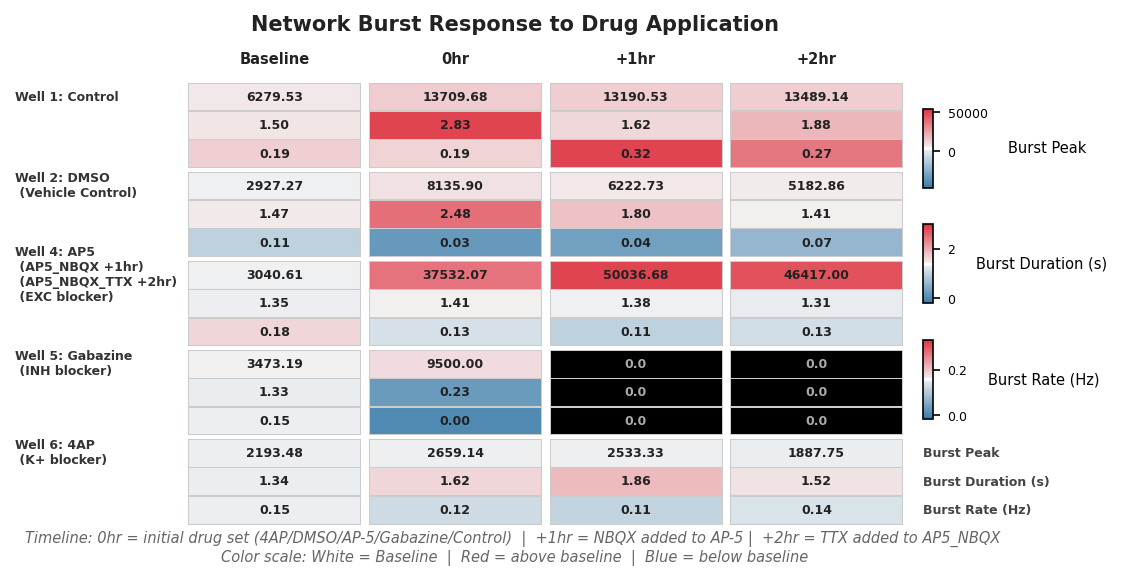



✓ Exported → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/Canine_Organoids_PVS/figures/organoid_drug_pct_change.csv


In [ ]:
# =============================================================================
# K9 Organoid Drug Treatment Analysis — Network Burst Heatmaps
# =============================================================================
# Experimental design:
#   Run 90  (Before):  Baseline — no drugs
#   Run 93  (0hr):     Immediate after drug: 4AP, DMSO, AP-5, Gabazine, AP-5, Control
#   Run 95  (+1hr):    1 hour later + NBQX added to wells 3&5 (AP-5 → AP-5_NBQX)
#   Run 97  (+2hr):    Another hour later + TTX added to wells 3&5 (AP-5_NBQX → AP-5_NBQX_TTX)
#
# Wells 1-6 map to treatments (same across all runs):
#   Well 1 = 4AP
#   Well 2 = DMSO
#   Well 3 = AP-5 (then AP-5_NBQX at +1hr, then AP-5_NBQX_TTX at +2hr)
#   Well 4 = Gabazine
#   Well 5 = AP-5 (then AP-5_NBQX at +1hr, then AP-5_NBQX_TTX at +2hr)
#   Well 6 = Control
#
# Heatmap shows % change from baseline (Run 90).
# =============================================================================

# ── Cell 1: Imports & Configuration ──────────────────────────────────────────

import os, json, re, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# Paths
BASE_DIR = Path("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/Canine_Organoids_PVS")
CSV_PATH = Path("/path/to/MaxTwo_Organoids_Assays_Canine_Organoids_PVS_.csv")  # UPDATE THIS

# Network burst metrics to extract and display
METRICS = {
    "nb_burst_peak":       "Burst Peak",
    "nb_duration_mean_s":  "Mean Burst Duration (s)",
    "nb_rate_hz":          "Burst Rate (Hz)",
}

# Timeline definition — specific Network Default runs
TIMELINE = {
    "Baseline": 90,   # baseline before any drugs
    "0hr":    93,   # immediate after first drug set
    "+1hr":   95,   # 1hr later + NBQX added to wells 3&5
    "+2hr":   97,   # another 1hr later + TTX added to wells 3&5
}

# Treatment mapping (well number → initial treatment)
# Wells 3&5 get cumulative additions over time
TREATMENTS = {
    1: "Control",
    2: "DMSO \n (Vehicle Control)",
    4: "AP5 \n (AP5_NBQX +1hr) \n (AP5_NBQX_TTX +2hr) \n (EXC blocker)",
    5: "Gabazine \n (INH blocker)",         # becomes AP-5_NBQX at +1hr, AP-5_NBQX_TTX at +2hr
    6: "4AP \n (K+ blocker)",
}


# ── Cell 2: Scan for network JSON files ──────────────────────────────────────

def scan_network_jsons(base_dir: Path) -> pd.DataFrame:
    """
    Scan directory tree for network_results.json files.
    Extract metadata from path structure:
      .../Canine_Organoids_PVS/<Date>/<ChipID>/Network/<RunID>/<WellID>/network_results.json
    """
    pattern = re.compile(
        r"Canine_Organoids_PVS[/\\]"
        r"(?P<date>\d+)[/\\]"
        r"(?P<chip_id>M\d+)[/\\]"
        r"Network[/\\]"
        r"(?P<run_id>\d+)[/\\]"
        r"(?P<well_id>well\d+)[/\\]"
        r"network_results\.json$",
        re.IGNORECASE
    )
    
    records = []
    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname.lower() != "network_results.json":
                continue
            full_path = Path(root) / fname
            rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
            m = pattern.search(str(full_path))
            if not m:
                continue
            
            well_idx = int(re.search(r"\d+", m.group("well_id")).group())
            well_num = well_idx + 1  # well000 → well 1
            
            records.append({
                "full_path": str(full_path),
                "date":      m.group("date"),
                "chip_id":   m.group("chip_id"),
                "run_num":   int(m.group("run_id")),
                "well_num":  well_num,
            })
    
    df = pd.DataFrame(records)
    print(f"✓ Found {len(df)} network_results.json files")
    if len(df) > 0:
        print(df[["chip_id", "run_num", "well_num"]].to_string(index=False))
    return df


file_df = scan_network_jsons(BASE_DIR)


# ── Cell 3: Extract network burst metrics ────────────────────────────────────

def extract_network_metrics(path: str) -> dict:
    """Extract network burst metrics from a network_results.json file."""
    out = {k: np.nan for k in METRICS}
    try:
        with open(path) as f:
            data = json.load(f)
        
        # New JSON format (post Dec 2025)
        if "network_bursts" in data and "metrics" in data["network_bursts"]:
            print("---DEBUG JSON STRUCTURE --- Top level keys:", list(data.keys()))
            m = data["network_bursts"]["metrics"]
            out["nb_count"]           = m.get("count")
            out["nb_rate_hz"]         = m.get("rate")
            out["nb_duration_mean_s"] = m.get("duration", {}).get("mean")
            out["nb_ibi_mean_s"]      = m.get("inter_event_interval", {}).get("mean")
            out["nb_burst_peak"]  =  m.get("burst_peak", {}).get("mean")
        
        # Old format (pre Dec 2025) — fallback
        elif "aggregates" in data:
            rec_dur = data.get("recording_end", 0) - data.get("recording_start", 0)
            nl = data.get("aggregates", {}).get("network_level", {})
            out["nb_count"]           = nl.get("count")
            out["nb_duration_mean_s"] = nl.get("mean_duration")
            if out["nb_count"] is not None and rec_dur > 0:
                out["nb_rate_hz"] = out["nb_count"] / rec_dur
            
            nb_list = data.get("network_bursts", [])
            if isinstance(nb_list, list) and len(nb_list) > 1:
                starts = sorted(b["start"] for b in nb_list if b.get("start") is not None)
                if len(starts) > 1:
                    ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                    out["nb_ibi_mean_s"] = np.nanmean(ibis)
    
    except Exception as e:
        print(f"  ⚠ Error reading {path}: {e}")
    
    return out


print("\nExtracting network burst metrics...")
metric_series = file_df["full_path"].apply(extract_network_metrics).apply(pd.Series)
data_df = pd.concat([file_df, metric_series], axis=1)
print(f"✓ Done. {len(data_df)} rows extracted")
print(data_df[["run_num", "well_num"] + list(METRICS.keys())].head(10).to_string(index=False))


# ── Cell 4: Build treatment mapping ──────────────────────────────────────────
# No need to parse CSV — we know the timeline and well→treatment mapping.

def build_treatment_df():
    """
    Create a lookup table: run_num × well_num → (timepoint, treatment)
    Wells 3 & 5 have cumulative drug additions.
    """
    records = []
    for timepoint, run_num in TIMELINE.items():
        for well_num, base_treatment in TREATMENTS.items():
            # Wells 3 & 5 get cumulative additions
            if well_num in [3, 5]:
                if timepoint == "+1hr":
                    treatment = f"{base_treatment}_NBQX"
                elif timepoint == "+2hr":
                    treatment = f"{base_treatment}_NBQX_TTX"
                else:
                    treatment = base_treatment
            else:
                treatment = base_treatment
            
            records.append({
                "run_num":   run_num,
                "well_num":  well_num,
                "timepoint": timepoint,
                "treatment": treatment,
            })
    
    return pd.DataFrame(records)


treatment_df = build_treatment_df()
print(f"\n✓ Built treatment lookup: {len(treatment_df)} run×well combinations")
print(treatment_df.to_string(index=False))


# ── Cell 5: Merge data with treatments ───────────────────────────────────────

merged = data_df.merge(
    treatment_df,
    on=["run_num", "well_num"],
    how="inner"
)

print(f"\n✓ Merged: {len(merged)} rows matched")
print("\nUnique treatments:", sorted(merged["treatment"].unique()))
print("Unique timepoints:", sorted(merged["timepoint"].unique()))
print("\nSample merged data:")
print(merged[["run_num", "well_num", "timepoint", "treatment", "nb_count", "nb_rate_hz", "nb_burst_peak"]].head(12).to_string(index=False))


# ── Cell 6: Compute % change from baseline ───────────────────────────────────
# Baseline = Run 90 (Before) per well.
# % change = 100 * (value - baseline) / baseline

BASELINE_RUN = 90

def compute_pct_change(df):
    """
    For each well + treatment + timepoint, compute % change from baseline (Run 90).
    """
    results = []
    
    for well_num in df["well_num"].unique():
        wdata = df[df["well_num"] == well_num].copy()
        
        for metric_key in METRICS.keys():
            # Get baseline value for this well (Run 90)
            baseline_vals = wdata.loc[wdata["run_num"] == BASELINE_RUN, metric_key].dropna()
            
            if len(baseline_vals) == 0:
                baseline = np.nan
            else:
                baseline = float(baseline_vals.iloc[0])  # only one value expected
            
            # Compute % change for each timepoint
            for _, row in wdata.iterrows():
                value = row[metric_key]
                if row["run_num"] == BASELINE_RUN:
                    pct_change = np.nan
                    timepoint_label = "Baseline" 
                    display_value = baseline
                elif pd.notna(baseline) and pd.notna(value) and baseline != 0:
                    pct_change = 100 * (value - baseline) / baseline
                    timepoint_label = row["timepoint"]
                else:
                    pct_change = np.nan
                    timepoint_label = row["timepoint"]
                
                results.append({
                    "well_num":   well_num,
                    "treatment":  row["treatment"],
                    "timepoint":  row["timepoint"],
                    "metric":     metric_key,
                    "baseline":   baseline,
                    "value":      value,
                    "pct_change": pct_change,
                })
    
    return pd.DataFrame(results)


pct_df = compute_pct_change(merged)
pct_df["row_label"] = pct_df["well_num"].map(lambda w: f"Well {w}: {TREATMENTS[w]}")
print(f"\n✓ Computed % change from baseline (Run {BASELINE_RUN}) for {len(pct_df)} datapoints")
print(pct_df.head(20).to_string(index=False))


# ── Cell 7: Create publication-quality heatmap ───────────────────────────────
# Combined 3-metric heatmap with split cells.
# Each cell shows: Burst Count | Burst Duration | IBI
# Color scale: baseline = white, above = red, below = blue

def make_combined_heatmap(df, save_dir=None):
    """
    Create a single publication-quality heatmap combining 3 metrics.
    Rows = wells × treatments
    Cols = timepoints
    Each cell is split into 3 sub-cells (count, duration, IBI)
    Color scale centered at baseline value for each metric.
    """
    
    print("\n" + "="*60)
    print("Building combined heatmap...")
    
    # Select 3 key metrics for the paper figure
    selected_metrics = {
        "nb_burst_peak":  "Burst Peak",
        "nb_duration_mean_s": "Burst Duration (s)",
        "nb_rate_hz":         "Burst Rate (Hz)",
    }
    
    print(f"  Filtering to 3 metrics: {list(selected_metrics.keys())}")
    mdata = df[df["metric"].isin(selected_metrics.keys())].copy()
    if len(mdata) == 0:
        print("  ⚠ No data for selected metrics")
        return
    print(f"  ✓ Filtered data: {len(mdata)} rows")
    
    # Create row labels
    print("  Creating row labels...")
    mdata["row_label"] = mdata.apply(
        lambda r: f"Well {r['well_num']}: {r['treatment']}", axis=1
    )
    
    # Get unique wells/timepoints for the grid
    #wells_ordered = sorted(mdata["well_num"].unique())
    wells_ordered = list(TREATMENTS.keys())
    row_labels = [f"Well {w}: {TREATMENTS[w]}" for w in wells_ordered]
    '''row_labels = [
        f"Well {w}: {mdata[mdata['well_num']==w]['treatment'].iloc[0]}"
        for w in wells_ordered
    ]'''
    timepoints_ordered = ["Baseline","0hr", "+1hr", "+2hr"]
    
    print(f"  Grid dimensions: {len(row_labels)} rows × {len(timepoints_ordered)} cols × {len(selected_metrics)} metrics")
    
    # Build a 3D structure: rows × cols × metrics
    # We'll plot this as a grid with 3 vertical sub-cells per main cell
    
    n_rows = len(row_labels)
    n_cols = len(timepoints_ordered)
    n_metrics = len(selected_metrics)
    print("DEBUGGG - unique wells:", wells_ordered , "unique timepoints:", timepoints_ordered)
    
    # Create figure with custom gridspec for split cells
    print("  Creating figure and GridSpec...")
    fig = plt.figure(figsize=(n_cols * 1.7, n_rows * 0.7), dpi=150)
    
    # Main grid: one "super-cell" per row×col
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(
        n_rows, n_cols,
        left=0.18, right=0.88, top=0.92, bottom=0.08,
        hspace=0.05, wspace=0.05
    )
    
    # For each row (well) and col (timepoint), create 3 vertical sub-cells
    print("  Creating subplot grid...")
    axes_grid = {}  # (row_idx, col_idx, metric_idx) → ax
    
    for ri, row_label in enumerate(row_labels):
        for ci, timepoint in enumerate(timepoints_ordered):
            # Create sub-grid within this super-cell
            sub_gs = gs[ri, ci].subgridspec(n_metrics, 1, hspace=0.02)
            for mi, (metric_key, _) in enumerate(selected_metrics.items()):
                ax = fig.add_subplot(sub_gs[mi, 0])
                axes_grid[(ri, ci, mi)] = ax
    print(f"  ✓ Created {len(axes_grid)} subplot axes")
    
    # ── Compute baseline and color normalization per metric ──────────────
    print("  Computing baseline values and color ranges...")
    baseline_values = {}   # metric_key → baseline value (mean across all wells)
    value_ranges = {}      # metric_key → (vmin, vmax) for color scaling
    
    for metric_key in selected_metrics.keys():
        baseline_vals = df.loc[df["metric"] == metric_key, "baseline"].dropna()
        if len(baseline_vals) > 0:
            baseline_values[metric_key] = float(baseline_vals.mean())
            print(f" DEBUGGGG: {metric_key}: computed baseline from data = {baseline_values[metric_key]:.2f}")
        else:
            baseline_values[metric_key] = 0.0
        
        # Determine vmin/vmax for symmetric scaling around baseline
        all_vals = df.loc[df["metric"] == metric_key, "value"].dropna()
        if len(all_vals) > 0:
            vmin = min(all_vals.min(), baseline_values[metric_key])
            vmax = max(all_vals.max(), baseline_values[metric_key])
            # Make symmetric around baseline
            spread = max(abs(vmax - baseline_values[metric_key]),
                        abs(baseline_values[metric_key] - vmin))
            value_ranges[metric_key] = (
                baseline_values[metric_key] - spread * 1.1,
                baseline_values[metric_key] + spread * 1.1
            )
        else:
            value_ranges[metric_key] = (0, 1)
        
        print(f"    {metric_key}: baseline={baseline_values[metric_key]:.2f}, range={value_ranges[metric_key]}")
    
    # ── Fill in each cell ─────────────────────────────────────────────────
    print("  Filling cells with data and colors...")
    cmap = sns.diverging_palette(240, 10, as_cmap=True, s=80, l=50)
    
    cell_count = 0
    total_cells = n_rows * n_cols * n_metrics
    
    for ri, row_label in enumerate(row_labels):
        well_num = wells_ordered[ri]
        
        for ci, timepoint in enumerate(timepoints_ordered):
            for mi, metric_key in enumerate(selected_metrics.keys()):
                cell_count += 1
                if cell_count % 10 == 0:
                    print(f"    Processing cell {cell_count}/{total_cells}...", end="\r")
                
                ax = axes_grid[(ri, ci, mi)]
                
                # Get value for this well × timepoint × metric
                cell_data = mdata[
                    (mdata["well_num"] == well_num) &
                    (mdata["timepoint"] == timepoint) &
                    (mdata["metric"] == metric_key)
                ]
                
                if len(cell_data) > 0:
                    value = cell_data["value"].iloc[0]
                    print(f" DEBUGGGG: Cell (Well {well_num}, Time {timepoint}, Metric {metric_key}) → value = {value}")
                else:
                    value = np.nan
                
                # Color mapping
                if pd.notna(value):
                    baseline = baseline_values[metric_key]
                    vmin, vmax = value_ranges[metric_key]
                    norm = TwoSlopeNorm(vmin=vmin, vcenter=baseline, vmax=vmax)
                    color = cmap(norm(value))
                    
                    # Display value as text
                    if metric_key == "nb_count":
                        text = f"{int(value)}" if value >= 1 else f"{value:.1f}"
                    else:
                        text = f"{value:.2f}"
                else:
                    color = "#000000" # black for dead data
                    text = "0.0"
                
                ax.set_facecolor(color)
                ax.text(0.5, 0.5, text, ha="center", va="center",
                       fontsize=6, fontweight="bold",
                       color="#222222" if pd.notna(value) else "#AAAAAA",
                       transform=ax.transAxes)
                
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_xticks([])
                ax.set_yticks([])
                
                # Border
                for spine in ax.spines.values():
                    spine.set_linewidth(0.5)
                    spine.set_edgecolor("#CCCCCC")
    
    print(f"\n  ✓ Filled all {total_cells} cells")
    
    # ── Row labels (wells) ────────────────────────────────────────────────
    print("  Adding row labels...")
    for ri, row_label in enumerate(row_labels):
        # Place text to the left of the first column
        ax_left = axes_grid[(ri, 0, 0)]
        fig.text(
            0.01, ax_left.get_position().y0 + ax_left.get_position().height / 2,
            row_label,
            ha="left", va="center", fontsize=6, fontweight="bold",
            color="#333333"
        )
    
    # ── Column labels (timepoints) ────────────────────────────────────────
    print("  Adding column labels...")
    for ci, timepoint in enumerate(timepoints_ordered):
        ax_top = axes_grid[(0, ci, 0)]
        fig.text(
            ax_top.get_position().x0 + ax_top.get_position().width / 2,
            0.95,
            timepoint,
            ha="center", va="bottom", fontsize=7, fontweight="bold",
            color="#222222"
        )
    
    # ── Metric labels (right side) ────────────────────────────────────────
    print("  Adding metric labels...")
    for mi, (metric_key, metric_short) in enumerate(selected_metrics.items()):
        ax_right = axes_grid[(n_rows // 2, n_cols - 1, mi)]
        fig.text(
            0.90, ax_right.get_position().y0 + ax_right.get_position().height / 2 - 0.34,
            metric_short,
            ha="left", va="center", fontsize=6, fontweight="bold",
            color="#444444", rotation=0
        )
    
    # ── Title ──────────────────────────────────────────────────────────────
    print("  Adding title and annotations...")
    fig.text(
        0.5, 1.05,
        "Network Burst Response to Drug Application",
        ha="center", va="top", fontsize=10, fontweight="bold",
        color="#222222"
    )
    
    # ── Timeline annotation ────────────────────────────────────────────────
    fig.text(
        0.5, 0.001,
        "Timeline: 0hr = initial drug set (4AP/DMSO/AP-5/Gabazine/Control)  |  "
        "+1hr = NBQX added to AP-5 |  +2hr = TTX added to AP5_NBQX \n"
        "Color scale: White = Baseline  |  Red = above baseline  |  Blue = below baseline",
        ha="center", va="bottom", fontsize=7, color="#666666",
        style="italic", multialignment="center"
    )
    
    # ── Colorbar legend ────────────────────────────────────────────────────
    print("  Adding colorbars...")
    # Add small colorbars on the right for each metric
    cbar_ax_positions = [
        (0.9, 0.72, 0.01, 0.15),   # Burst Count
        (0.9, 0.50, 0.01, 0.15),   # Duration
        (0.9, 0.28, 0.01, 0.15),   # IBI
    ]
    
    for mi, (metric_key, metric_label) in enumerate(selected_metrics.items()):
        baseline = baseline_values[metric_key]
        vmin, vmax = value_ranges[metric_key]
        norm = TwoSlopeNorm(vmin=vmin, vcenter=baseline, vmax=vmax)
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        cbar_ax = fig.add_axes(cbar_ax_positions[mi])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=6)
        cbar.set_label(metric_label.replace("\n", " "), fontsize=7, rotation=0,
                      ha="left", va="center", labelpad=10)
        
        # Mark baseline with horizontal line
        cbar.ax.axhline(baseline, color="white", linewidth=1.5, linestyle="--", alpha=0.8)
    
    print("  ✓ Colorbars complete")
    
    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out = Path(save_dir) / "Figure_DrugResponse_Combined.png"
        print(f"  Saving figure to {out}...")
        fig.savefig(out, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"  ✓ Saved publication figure → {out}")
    
    print("  Displaying figure...")
    plt.show()
    print("="*60 + "\n")


SAVE_DIR = BASE_DIR / "figures"
make_combined_heatmap(pct_df, save_dir=SAVE_DIR)


# ── Cell 8: Export tidy data ──────────────────────────────────────────────────

out_csv = BASE_DIR / "figures" / "organoid_drug_pct_change.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
pct_df.to_csv(out_csv, index=False)
print(f"\n✓ Exported → {out_csv}")

In [53]:
import json
from pathlib import Path

# Pick ONE file to inspect
example_path = file_df["full_path"].iloc[0]
print("Inspecting:", example_path)

with open(example_path) as f:
    data = json.load(f)

print("\nTop-level keys:")
print(data.keys())

# If network_bursts exists
if "network_bursts" in data:
    print("\nKeys inside 'network_bursts':")
    
    if isinstance(data["network_bursts"], dict):
        print(data["network_bursts"].keys())
        
        if "metrics" in data["network_bursts"]:
            print("\nKeys inside 'network_bursts[\"metrics\"]':")
            print(data["network_bursts"]["metrics"].keys())
    
    elif isinstance(data["network_bursts"], list):
        print("network_bursts is a list.")
        if len(data["network_bursts"]) > 0:
            print("Keys inside first burst:")
            print(data["network_bursts"][0].keys())

# 🔎 Automatically search for anything containing 'peak'
print("\nSearching for keys containing 'peak'...")

def search_for_peak(d, prefix=""):
    if isinstance(d, dict):
        for k, v in d.items():
            if "peak" in k.lower():
                print(f"Found key: {prefix}{k}")
            search_for_peak(v, prefix + k + ".")
    elif isinstance(d, list):
        for i, item in enumerate(d):
            search_for_peak(item, prefix + f"[{i}].")

search_for_peak(data)

Inspecting: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/Canine_Organoids_PVS/250619/M08020/Network/000090/well005/network_results.json

Top-level keys:
dict_keys(['burstlets', 'network_bursts', 'superbursts', 'diagnostics', 'plot_data', 'n_units'])

Keys inside 'network_bursts':
dict_keys(['events', 'metrics'])

Keys inside 'network_bursts["metrics"]':
dict_keys(['count', 'rate', 'duration', 'inter_event_interval', 'intensity', 'participation', 'spikes_per_burst', 'burst_peak'])

Searching for keys containing 'peak'...
Found key: burstlets.events.[0].peak_synchrony
Found key: burstlets.events.[0].peak_time
Found key: burstlets.events.[0].burst_peak
Found key: burstlets.events.[1].peak_synchrony
Found key: burstlets.events.[1].peak_time
Found key: burstlets.events.[1].burst_peak
Found key: burstlets.events.[2].peak_synchrony
Found key: burstlets.events.[2].peak_time
Found key: burstlets.events.[2].burst_peak
Found key: burstlets.events.[3]

In [67]:

# New JSON format (post Dec 2025)
if "network_bursts" in data and "metrics" in data["network_bursts"]:
    m = data["network_bursts"]["metrics"]
    data["nb_burst_peak"]  =  m.get("burst_peak", {}).get("mean")
    print(data["nb_burst_peak"].get("mean"))

AttributeError: 'float' object has no attribute 'get'